<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182 (from 1)
Receiving objects: 100% (254/254), 94.70 MiB | 37.43 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22738 sha256=631b394cc8542c9e9d202b69a3a29059f962804d4a45b6fdc8c9dafc66fcd9b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-rh7lef93/wheels/56/a7/ca/73bb6596cf7cbc2cb50d8e78ee9a443f565387de4274f72447
Successfully built deepul


In [5]:
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

In [6]:
ptu.set_gpu_mode(True)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm, trange, tqdm_notebook

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')

# Question 1: Warmup [20pt]

In this question, we will train different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

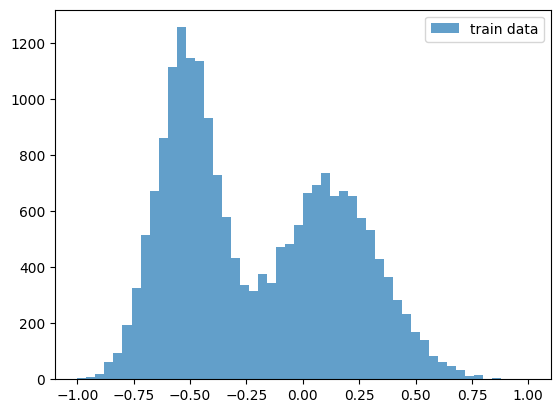

In [3]:
visualize_q1_dataset()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import tqdm, trange, tqdm_notebook

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 
* 3 layers
* 128 hidden dim
* LeakyReLU nonlinearities with negative_slope=0.2

### Solution

In [70]:
def q1a_generate_results(model_d, model_g):
  model_d.eval()
  model_g.eval()
  with torch.no_grad():
    samples = model_g(torch.randn(5000, 1)).view(-1)
    linspace = torch.tensor(np.linspace(-1, 1, 1000)).view(-1, 1).float()
    probs = F.sigmoid(model_d(linspace))
  return samples.numpy(), probs.numpy()

def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    model_d = nn.Sequential(
      nn.Linear(1, 128),
      nn.LeakyReLU(negative_slope=0.2),
      nn.Linear(128, 128),
      nn.LeakyReLU(negative_slope=0.2),
      nn.Linear(128, 1),
    )
    model_g = nn.Sequential(
      nn.Linear(1, 128),
      nn.LeakyReLU(negative_slope=0.2),
      nn.Linear(128, 128),
      nn.LeakyReLU(negative_slope=0.2),
      nn.Linear(128, 1),
    )

    learning_rate = 1e-6
    optimizer_d = optim.Adam(model_d.parameters(), lr=learning_rate)
    optimizer_g = optim.Adam(model_g.parameters(), lr=learning_rate)

    batch_size = 100
    train_data = torch.tensor(train_data).float()
    dataloader = DataLoader(TensorDataset(train_data), batch_size, shuffle=True)
    
    d_losses = []
    n_epochs = 200
    for epoch in tqdm(range(n_epochs)):
      for (real_batch,) in dataloader:
        # train discriminator
        model_d.train()
        model_g.eval()
        N = real_batch.shape[0]
        real_batch.unsqueeze(1)
        with torch.no_grad():
          gen_batch = model_g(torch.randn(N, 1))
        x = torch.concat([real_batch, gen_batch], dim=0)
        y = torch.concat([torch.ones(N), torch.zeros(N)], dim=0)
        logits = model_d(x).view(-1)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        d_losses.append(loss.item())

        optimizer_d.zero_grad()
        loss.backward()
        optimizer_d.step()

        # train generator
        model_g.train()
        model_d.eval()
        gen_batch = model_g(torch.randn(N, 1))
        x = torch.concat([real_batch, gen_batch], dim=0)
        y = torch.concat([torch.ones(N), torch.zeros(N)], dim=0)
        logits = model_d(x).view(-1)
        loss = -F.binary_cross_entropy_with_logits(logits, y)
        
        optimizer_g.zero_grad()
        loss.backward()
        optimizer_g.step()

      # generate results
      if epoch == 0:
        initial_samples, initial_probs = q1a_generate_results(model_d, model_g)

    final_samples, final_probs = q1a_generate_results(model_d, model_g)

    linspace = np.linspace(-1, 1, 1000)
    return d_losses, initial_samples, linspace, initial_probs, final_samples, linspace, final_probs
        

### Results

100%|██████████| 200/200 [00:37<00:00,  5.39it/s]


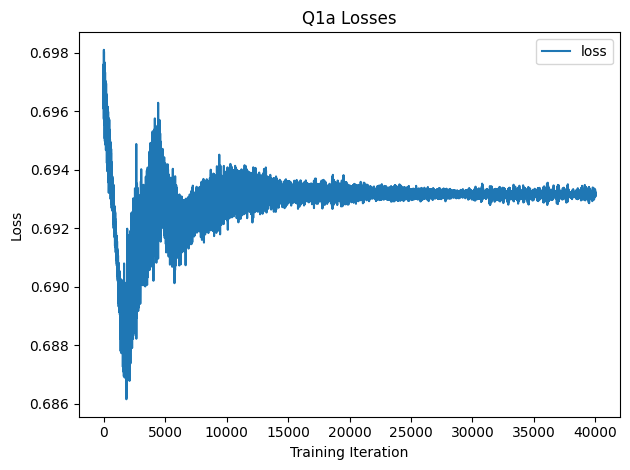

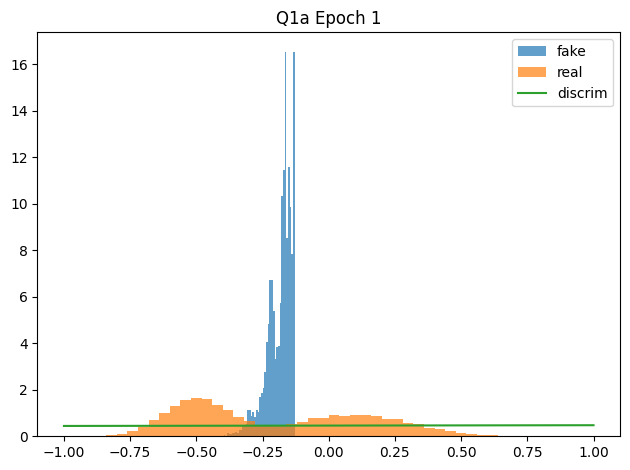

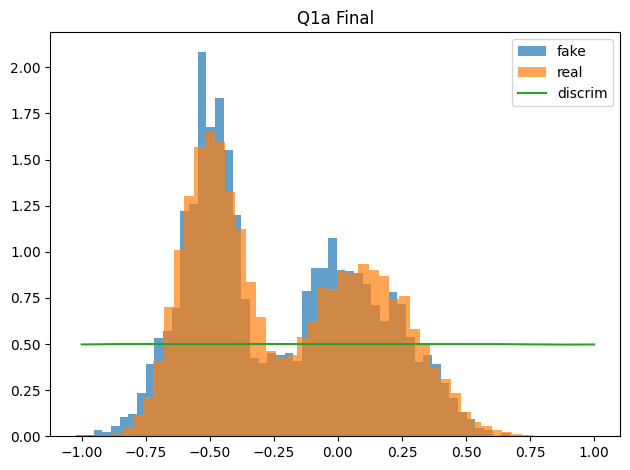

In [71]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate objectives:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G)} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z)))$$

 ### Solution

In [77]:
def q1b_generate_results(model_d, model_g):
  model_d.eval()
  model_g.eval()
  with torch.no_grad():
    samples = model_g(torch.randn(5000, 1)).view(-1)
    linspace = torch.tensor(np.linspace(-1, 1, 1000)).view(-1, 1).float()
    probs = F.sigmoid(model_d(linspace))
  return samples.numpy(), probs.numpy()

def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """

    model_d = nn.Sequential(
      nn.Linear(1, 128),
      nn.LeakyReLU(negative_slope=0.2),
      nn.Linear(128, 128),
      nn.LeakyReLU(negative_slope=0.2),
      nn.Linear(128, 1),
    )
    model_g = nn.Sequential(
      nn.Linear(1, 128),
      nn.LeakyReLU(negative_slope=0.2),
      nn.Linear(128, 128),
      nn.LeakyReLU(negative_slope=0.2),
      nn.Linear(128, 1),
    )

    learning_rate = 1e-6
    optimizer_d = optim.Adam(model_d.parameters(), lr=learning_rate)
    optimizer_g = optim.Adam(model_g.parameters(), lr=learning_rate)

    batch_size = 100
    train_data = torch.tensor(train_data).float()
    dataloader = DataLoader(TensorDataset(train_data), batch_size, shuffle=True)
    
    d_losses = []
    n_epochs = 200
    for epoch in tqdm(range(n_epochs)):
      for (real_batch,) in dataloader:
        # train discriminator
        model_d.train()
        model_g.eval()
        N = real_batch.shape[0]
        real_batch.unsqueeze(1)
        with torch.no_grad():
          gen_batch = model_g(torch.randn(N, 1))
        x = torch.concat([real_batch, gen_batch], dim=0)
        y = torch.concat([torch.ones(N), torch.zeros(N)], dim=0)
        logits = model_d(x).view(-1)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        d_losses.append(loss.item())

        optimizer_d.zero_grad()
        loss.backward()
        optimizer_d.step()

        # train generator
        model_g.train()
        model_d.eval()
        x = model_g(torch.randn(N, 1))
        y = torch.ones(N)
        logits = model_d(x).view(-1)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        
        optimizer_g.zero_grad()
        loss.backward()
        optimizer_g.step()

      # generate results
      if epoch == 0:
        initial_samples, initial_probs = q1a_generate_results(model_d, model_g)

    final_samples, final_probs = q1a_generate_results(model_d, model_g)

    linspace = np.linspace(-1, 1, 1000)
    return d_losses, initial_samples, linspace, initial_probs, final_samples, linspace, final_probs

 ### Results

100%|██████████| 200/200 [00:35<00:00,  5.62it/s]


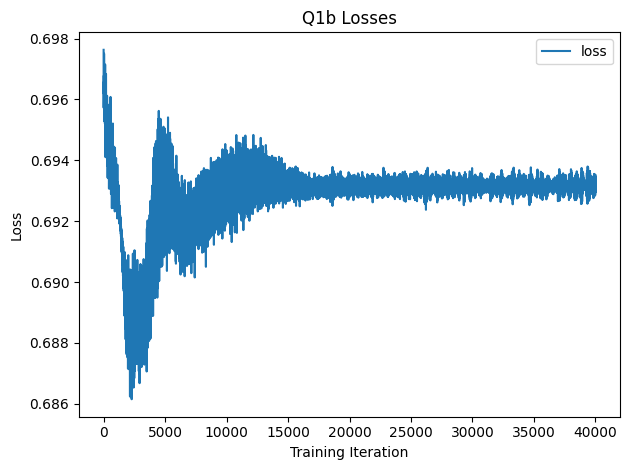

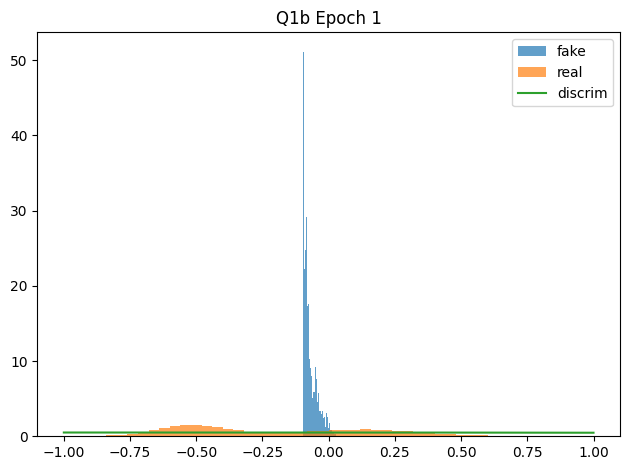

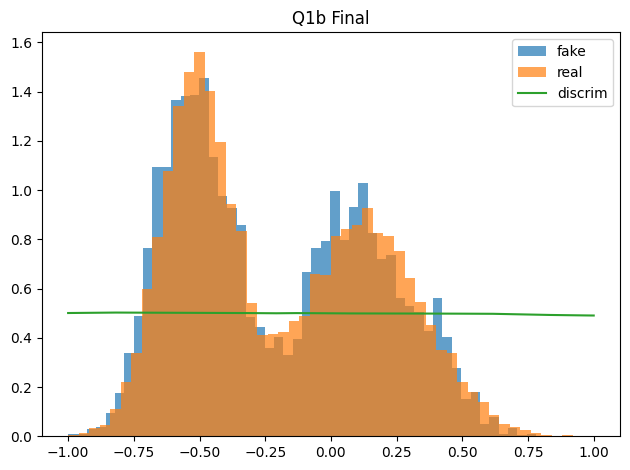

In [78]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train a GAN on CIFAR-10. Execute the cell below to visualize the dataset. 

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:02<00:00, 57340354.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


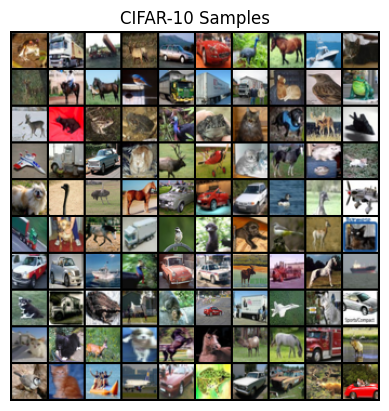

In [8]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf) (see page 17), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
The discriminator (no BatchNorm!).
```
def Discriminator(*):
    def __init__(self, n_filters=128):
        ResnetBlockDown(3, n_filters=n_filters),
        ResnetBlockDown(128, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        nn.ReLU()
        global sum pooling
        nn.Linear(128, 1)
```


**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

 ### Models

In [54]:
class ResBlock(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.conv1 = nn.Conv2d(n_filters, n_filters, kernel_size=1, stride=1, padding=0)
    self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(n_filters, n_filters, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    x_orig = x
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    return self.conv3(x) + x_orig

class DepthToSpace(nn.Module):
  def __init__(self, block_size):
    super().__init__()
    self.block_size = block_size

  def forward(self, x):
    x = x.permute((0, 2, 3, 1))
    N, H, W, D = x.shape
    B = self.block_size
    x = x.view(N, H, W, B, B, -1)
    x = x.permute((0, 1, 3, 2, 4, 5))
    x = x.reshape(N, H*B, W*B, -1)
    x = x.permute((0, 3, 1, 2))
    return x

class SpaceToDepth(nn.Module):
  def __init__(self, block_size):
    super().__init__()
    self.block_size = block_size
  
  def forward(self, x):
    x = x.permute((0, 2, 3, 1))
    N, H, W, D = x.shape
    B = self.block_size
    x = x.view(N, H//B, B, W//B, B, -1)
    x = x.permute((0, 1, 3, 2, 4, 5))
    x = x.reshape(N, H//B, W//B, -1)
    x = x.permute((0, 3, 1, 2))
    return x

class UpsampleConv2d(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.depth_to_space = DepthToSpace(2)
    self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding)

  def forward(self, x):
    x = torch.cat([x, x, x, x], dim=1)
    x = self.depth_to_space(x)
    x = self.conv(x)
    return x

class DownsampleConv2d(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.space_to_depth = SpaceToDepth(2)
    self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding)

  def forward(self, x):
    x = self.space_to_depth(x)
    N, D, H, W = x.shape
    x = x.view(N, 4, D//4, H, W)
    x = x.permute((1, 0, 2, 3, 4))
    x = torch.mean(x, dim=0)
    x = self.conv(x)
    return x

class ResBlockUp(nn.Module):
  def __init__(self, in_dim, n_filters):
    super().__init__()
    self.bn1 = nn.BatchNorm2d(in_dim)
    self.conv = nn.Conv2d(in_dim, n_filters, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(n_filters)
    self.residual = UpsampleConv2d(n_filters, n_filters)
    self.shortcut = UpsampleConv2d(in_dim, n_filters, kernel_size=1, stride=1, padding=0)
  
  def forward(self, x):
    y = self.residual(F.relu(self.bn2(self.conv(F.relu(self.bn1(x))))))
    z = self.shortcut(x)
    return y + z

class ResBlockDown(nn.Module):
  def __init__(self, in_dim, n_filters):
    super().__init__()
    self.conv = nn.Conv2d(in_dim, n_filters, kernel_size=3, stride=1, padding=1)
    self.residual = DownsampleConv2d(n_filters, n_filters)
    self.shortcut = DownsampleConv2d(in_dim, n_filters, kernel_size=1, stride=1, padding=0)
  
  def forward(self, x):
    y = self.residual(F.relu(self.conv(F.relu(x))))
    z = self.shortcut(x)
    return y + z

class Generator(nn.Module):
  def __init__(self, n_latents=128, n_filters=128):
    super().__init__()
    self.n_latents = n_latents
    self.fc = nn.Linear(n_latents, 4*4*256)
    self.res_block_up1 = ResBlockUp(256, n_filters)       #256x4x4 -> 128x8x8
    self.res_block_up2 = ResBlockUp(n_filters, n_filters) #128x8x8 -> 128x16x16
    self.res_block_up3 = ResBlockUp(n_filters, n_filters) #128x16x16 -> 128x32x32
    self.bn = nn.BatchNorm2d(n_filters)
    self.conv = nn.Conv2d(n_filters, 3, kernel_size=3, stride=1, padding=1)

  def forward(self, n_samples):
    x = torch.randn(n_samples, self.n_latents).to(device)
    x = self.fc(x).view(n_samples, 256, 4, 4)
    x = self.res_block_up1(x)
    x = self.res_block_up2(x)
    x = self.res_block_up3(x)
    x = self.conv(F.relu(self.bn(x)))
    x = F.tanh(x)
    return x

class Critic(nn.Module):
  def __init__(self, n_filters=128):
    super().__init__()
    self.res_block_down1 = ResBlockDown(3, n_filters)         # 3x32x32 -> 128x16x16
    self.res_block_down2 = ResBlockDown(n_filters, n_filters) # 128x16x16 -> 128x8x8
    self.res_block1 = ResBlock(n_filters)
    self.res_block2 = ResBlock(n_filters)
    self.fc = nn.Linear(n_filters, 1)

  def forward(self, x):
    x = self.res_block_down1(x)
    x = self.res_block_down2(x)
    x = self.res_block1(x)
    x = F.relu(self.res_block2(x))
    x = F.avg_pool2d(x, kernel_size=x.shape[-2:], padding=0)
    x = self.fc(x.view(x.shape[0], -1))
    return x

In [59]:
from torch.func import grad, vmap

def q2(train_data):
  """
  train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

  Returns
  - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
  - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
      The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
  """

  """ YOUR CODE HERE """
  batch_size = 256
  train_data = torch.tensor((train_data-0.5) * 2).float()
  dataloader = DataLoader(TensorDataset(train_data), batch_size, shuffle=True)

  learning_rate = 2e-4
  generator = Generator().to(device)
  critic = Critic().to(device)
  optim_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0, 0.9))
  optim_c = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0, 0.9))

  # lambda_coeff = 10
  weight_limit = 1e-2
  n_train_steps = 25_00
  n_critic = 5
  n_epochs = n_train_steps // len(dataloader) + 1
  losses = []
  pbar = tqdm(total=n_epochs)
  pbar.set_postfix({'loss': 0})
  for epoch in tqdm(range(n_epochs)):
    for (batch,) in dataloader:
      generator.eval()
      critic.train()
      N = len(batch)
      x_data = batch.to(device)
      x_gen = generator(n_samples=N)
      loss = torch.mean(critic(x_gen) - critic(x_data))
      # x_hat = x_data + (x_gen - x_data) * torch.rand(*x_gen.shape).to(device)
      # x_hat = x_hat.unsqueeze(1)
      # critic_grad = vmap(grad(lambda x: critic(x).squeeze()))(x_hat).squeeze(1)
      # gradient_penalty = torch.mean((torch.linalg.norm(critic_grad.reshape(N, -1), dim=1) - 1)**2)
      # loss = critic_loss + lambda_coeff * gradient_penalty
      losses.append(loss.item())
      pbar.set_postfix({'loss': loss.item()})

      optim_c.zero_grad()
      loss.backward()
      optim_c.step()
      for param in critic.parameters():
        param.data.clamp_(-weight_limit, weight_limit)

      if len(losses) % n_critic == 0:
        generator.train()
        critic.eval()
        x_gen = generator(n_samples=batch_size)
        loss = -torch.mean(critic(x_gen))

        optim_g.zero_grad()
        loss.backward()
        optim_g.step()
    pbar.update(1)

  generator.eval()
  with torch.no_grad():
    samples = generator(n_samples=1000).permute((0, 2, 3, 1)).cpu().numpy() / 2 + 0.5
  return losses, samples

## Results

Files already downloaded and verified


  0%|                                                                                            | 0/13 [00:00<?, ?it/s]

Epoch 0: training loss = 0.03270873799920082
Epoch 0: training loss = -4.6634842874482274e-05
Epoch 0: training loss = -5.8662004448706284e-05
Epoch 0: training loss = -7.779656152706593e-05
Epoch 0: training loss = -0.00010616375948302448
Epoch 0: training loss = -0.00012420539860613644
Epoch 0: training loss = -0.00014631242083851248
Epoch 0: training loss = -0.00018789780733641237
Epoch 0: training loss = -0.00023406516993418336
Epoch 0: training loss = -0.0002941621351055801
Epoch 0: training loss = -0.00034968904219567776
Epoch 0: training loss = -0.0004189038008917123
Epoch 0: training loss = -0.000542275607585907
Epoch 0: training loss = -0.0006869928911328316
Epoch 0: training loss = -0.0008665265049785376
Epoch 0: training loss = -0.001004565041512251
Epoch 0: training loss = -0.0012491431552916765
Epoch 0: training loss = -0.00154679745901376
Epoch 0: training loss = -0.002025438705459237
Epoch 0: training loss = -0.002687660977244377
Epoch 0: training loss = -0.0029893908649

  8%|██████▍                                                                             | 1/13 [00:15<03:03, 15.32s/it]

Epoch 0: training loss = -1.8789716958999634
Epoch 1: training loss = -1.8265622854232788
Epoch 1: training loss = -2.009671449661255
Epoch 1: training loss = -1.970017433166504
Epoch 1: training loss = -2.364201068878174
Epoch 1: training loss = -2.39070987701416
Epoch 1: training loss = -2.3111000061035156
Epoch 1: training loss = -2.6261544227600098
Epoch 1: training loss = -3.284052848815918
Epoch 1: training loss = -3.774962902069092
Epoch 1: training loss = -1.3760764598846436
Epoch 1: training loss = -1.0118486881256104
Epoch 1: training loss = -1.1184101104736328
Epoch 1: training loss = -1.483397364616394
Epoch 1: training loss = -2.1088247299194336
Epoch 1: training loss = 6.283638954162598
Epoch 1: training loss = 3.840128183364868
Epoch 1: training loss = 2.9735779762268066
Epoch 1: training loss = 2.131641149520874
Epoch 1: training loss = 2.232494831085205
Epoch 1: training loss = 3.8651227951049805
Epoch 1: training loss = 2.837733268737793
Epoch 1: training loss = 2.237

 15%|████████████▉                                                                       | 2/13 [00:30<02:48, 15.30s/it]

Epoch 2: training loss = 0.8856847286224365
Epoch 2: training loss = 1.3297462463378906
Epoch 2: training loss = -0.6763513088226318
Epoch 2: training loss = 2.9426088333129883
Epoch 2: training loss = 1.247321367263794
Epoch 2: training loss = 0.6958064436912537
Epoch 2: training loss = -0.5028126239776611
Epoch 2: training loss = -8.480892181396484
Epoch 2: training loss = -2.91287899017334
Epoch 2: training loss = -4.384306907653809
Epoch 2: training loss = -6.232487678527832
Epoch 2: training loss = -9.900236129760742
Epoch 2: training loss = -10.207927703857422
Epoch 2: training loss = 3.732442855834961
Epoch 2: training loss = 2.252157211303711
Epoch 2: training loss = 1.4719618558883667
Epoch 2: training loss = 1.805501937866211
Epoch 2: training loss = 0.3419240117073059
Epoch 2: training loss = 2.746502637863159
Epoch 2: training loss = 1.461848497390747
Epoch 2: training loss = 0.011800773441791534
Epoch 2: training loss = -1.7195274829864502
Epoch 2: training loss = -3.42951

 23%|███████████████████▍                                                                | 3/13 [00:45<02:32, 15.26s/it]

Epoch 3: training loss = -4.737308502197266
Epoch 3: training loss = -8.26000690460205
Epoch 3: training loss = 39.963043212890625
Epoch 3: training loss = 18.15705108642578
Epoch 3: training loss = 9.408058166503906
Epoch 3: training loss = 7.354098796844482
Epoch 3: training loss = 4.665616512298584
Epoch 3: training loss = 3.0993692874908447
Epoch 3: training loss = 0.06697649508714676
Epoch 3: training loss = -2.0354433059692383
Epoch 3: training loss = -2.7490968704223633
Epoch 3: training loss = -3.318962812423706
Epoch 3: training loss = -3.644535779953003
Epoch 3: training loss = -4.110649585723877
Epoch 3: training loss = -4.298917770385742
Epoch 3: training loss = -5.518863677978516
Epoch 3: training loss = -6.7617692947387695
Epoch 3: training loss = -5.060036659240723
Epoch 3: training loss = -6.394016265869141
Epoch 3: training loss = -7.547935485839844
Epoch 3: training loss = -6.718021392822266
Epoch 3: training loss = -8.01814079284668
Epoch 3: training loss = -7.160163

 31%|█████████████████████████▊                                                          | 4/13 [01:01<02:17, 15.31s/it]

Epoch 4: training loss = -3.6237852573394775
Epoch 4: training loss = -2.641439914703369
Epoch 4: training loss = -2.204516887664795
Epoch 4: training loss = -1.838125228881836
Epoch 4: training loss = -3.1290383338928223
Epoch 4: training loss = -4.500687122344971
Epoch 4: training loss = -2.4168691635131836
Epoch 4: training loss = -3.0178518295288086
Epoch 4: training loss = -0.9940532445907593
Epoch 4: training loss = -3.6397299766540527
Epoch 4: training loss = -1.749776840209961
Epoch 4: training loss = 4.794029235839844
Epoch 4: training loss = 0.9096997976303101
Epoch 4: training loss = 0.04611710458993912
Epoch 4: training loss = -0.7071619033813477
Epoch 4: training loss = -1.4786651134490967
Epoch 4: training loss = 0.46177059412002563
Epoch 4: training loss = -1.8894096612930298
Epoch 4: training loss = -4.362231731414795
Epoch 4: training loss = -6.658392906188965
Epoch 4: training loss = -12.536054611206055
Epoch 4: training loss = 11.938432693481445
Epoch 4: training los

 38%|████████████████████████████████▎                                                   | 5/13 [01:16<02:02, 15.32s/it]

Epoch 5: training loss = -28.354637145996094
Epoch 5: training loss = -29.592357635498047
Epoch 5: training loss = -37.63991165161133
Epoch 5: training loss = -35.42856979370117
Epoch 5: training loss = -35.70227813720703
Epoch 5: training loss = -39.53288650512695
Epoch 5: training loss = -38.6750602722168
Epoch 5: training loss = -42.0147590637207
Epoch 5: training loss = -37.50481414794922
Epoch 5: training loss = -44.435882568359375
Epoch 5: training loss = -39.226158142089844
Epoch 5: training loss = -41.921173095703125
Epoch 5: training loss = -36.49509811401367
Epoch 5: training loss = -37.3145866394043
Epoch 5: training loss = -32.82908248901367
Epoch 5: training loss = -16.8421573638916
Epoch 5: training loss = -15.624954223632812
Epoch 5: training loss = -23.33367156982422
Epoch 5: training loss = -20.990806579589844
Epoch 5: training loss = -29.582244873046875
Epoch 5: training loss = 6.7287468910217285
Epoch 5: training loss = -35.989959716796875
Epoch 5: training loss = -4

 46%|██████████████████████████████████████▊                                             | 6/13 [01:31<01:47, 15.34s/it]

Epoch 6: training loss = -24.960208892822266
Epoch 6: training loss = -27.841894149780273
Epoch 6: training loss = -31.787372589111328
Epoch 6: training loss = -30.12343978881836
Epoch 6: training loss = 14.385943412780762
Epoch 6: training loss = 3.345872402191162
Epoch 6: training loss = -2.6240365505218506
Epoch 6: training loss = -9.294358253479004
Epoch 6: training loss = -12.508631706237793
Epoch 6: training loss = -2.459909200668335
Epoch 6: training loss = -20.639923095703125
Epoch 6: training loss = -24.297449111938477
Epoch 6: training loss = -29.92799186706543
Epoch 6: training loss = -32.637271881103516
Epoch 6: training loss = 22.072999954223633
Epoch 6: training loss = 9.536800384521484
Epoch 6: training loss = -15.12746810913086
Epoch 6: training loss = -32.12833023071289
Epoch 6: training loss = -34.863494873046875
Epoch 6: training loss = -15.027606964111328
Epoch 6: training loss = -13.180461883544922
Epoch 6: training loss = -18.836956024169922
Epoch 6: training loss

 54%|█████████████████████████████████████████████▏                                      | 7/13 [01:47<01:31, 15.29s/it]

Epoch 7: training loss = -0.027866002172231674
Epoch 7: training loss = -0.03214900195598602
Epoch 7: training loss = -0.03959464654326439
Epoch 7: training loss = -0.04614479839801788
Epoch 7: training loss = -0.05934596434235573
Epoch 7: training loss = -0.0713813379406929
Epoch 7: training loss = -0.0803295150399208
Epoch 7: training loss = -0.11261772364377975
Epoch 7: training loss = -0.15722507238388062
Epoch 7: training loss = -0.22482822835445404
Epoch 7: training loss = -0.8675371408462524
Epoch 7: training loss = -2.0486021041870117
Epoch 7: training loss = -3.3334264755249023
Epoch 7: training loss = -4.06033182144165
Epoch 7: training loss = -4.836989402770996
Epoch 7: training loss = -5.686395168304443
Epoch 7: training loss = -6.71939754486084
Epoch 7: training loss = -8.015388488769531
Epoch 7: training loss = -6.855030536651611
Epoch 7: training loss = -7.889956474304199
Epoch 7: training loss = -9.293550491333008
Epoch 7: training loss = -9.565589904785156
Epoch 7: tra

 62%|███████████████████████████████████████████████████▋                                | 8/13 [02:02<01:16, 15.30s/it]

Epoch 8: training loss = -19.50812530517578
Epoch 8: training loss = -21.56792449951172
Epoch 8: training loss = -21.507904052734375
Epoch 8: training loss = -23.04998016357422
Epoch 8: training loss = -24.98124885559082
Epoch 8: training loss = -29.408870697021484
Epoch 8: training loss = -35.66307830810547
Epoch 8: training loss = -34.991310119628906
Epoch 8: training loss = -34.584163665771484
Epoch 8: training loss = -37.32042694091797
Epoch 8: training loss = -43.84300231933594
Epoch 8: training loss = -51.564453125
Epoch 8: training loss = -47.776817321777344
Epoch 8: training loss = -50.54773712158203
Epoch 8: training loss = -53.53859329223633
Epoch 8: training loss = -55.59899139404297
Epoch 8: training loss = -57.741188049316406
Epoch 8: training loss = -46.94769287109375
Epoch 8: training loss = -47.906402587890625
Epoch 8: training loss = -53.184783935546875
Epoch 8: training loss = -55.829254150390625
Epoch 8: training loss = -60.55784225463867
Epoch 8: training loss = -42

 69%|██████████████████████████████████████████████████████████▏                         | 9/13 [02:17<01:01, 15.30s/it]

Epoch 8: training loss = -14.413150787353516
Epoch 8: training loss = -14.972813606262207
Epoch 9: training loss = -14.313150405883789
Epoch 9: training loss = -21.30219078063965
Epoch 9: training loss = -22.443889617919922
Epoch 9: training loss = -22.652467727661133
Epoch 9: training loss = -24.552310943603516
Epoch 9: training loss = -25.12514877319336
Epoch 9: training loss = -10.615621566772461
Epoch 9: training loss = -9.529975891113281
Epoch 9: training loss = -10.920372009277344
Epoch 9: training loss = -11.35131549835205
Epoch 9: training loss = -11.039660453796387
Epoch 9: training loss = -10.708648681640625
Epoch 9: training loss = -12.186141967773438
Epoch 9: training loss = -14.242288589477539
Epoch 9: training loss = -14.86478328704834
Epoch 9: training loss = -13.214752197265625
Epoch 9: training loss = -9.860310554504395
Epoch 9: training loss = -12.426485061645508
Epoch 9: training loss = -9.356741905212402
Epoch 9: training loss = -12.399492263793945
Epoch 9: training

 77%|███████████████████████████████████████████████████████████████▊                   | 10/13 [02:33<00:46, 15.36s/it]

Epoch 10: training loss = -0.1558682918548584
Epoch 10: training loss = -0.9478710889816284
Epoch 10: training loss = -1.6362991333007812
Epoch 10: training loss = -1.8048255443572998
Epoch 10: training loss = -2.744826316833496
Epoch 10: training loss = 0.6085731983184814
Epoch 10: training loss = -1.2563543319702148
Epoch 10: training loss = -1.311030626296997
Epoch 10: training loss = -1.4319982528686523
Epoch 10: training loss = -1.918076515197754
Epoch 10: training loss = -2.1347103118896484
Epoch 10: training loss = -2.5652103424072266
Epoch 10: training loss = -3.176934003829956
Epoch 10: training loss = -5.310674667358398
Epoch 10: training loss = -7.631315231323242
Epoch 10: training loss = -0.059844791889190674
Epoch 10: training loss = -3.3974337577819824
Epoch 10: training loss = -2.881347179412842
Epoch 10: training loss = -4.561291694641113
Epoch 10: training loss = -5.107956409454346
Epoch 10: training loss = -7.092635631561279
Epoch 10: training loss = -9.29195404052734

 85%|██████████████████████████████████████████████████████████████████████▏            | 11/13 [02:48<00:30, 15.34s/it]

Epoch 11: training loss = 4.776604652404785
Epoch 11: training loss = 3.628561019897461
Epoch 11: training loss = 3.3947629928588867
Epoch 11: training loss = 2.6712913513183594
Epoch 11: training loss = 3.1495285034179688
Epoch 11: training loss = 1.643591284751892
Epoch 11: training loss = 1.610236406326294
Epoch 11: training loss = 1.069261074066162
Epoch 11: training loss = 0.9981192946434021
Epoch 11: training loss = 0.8570995330810547
Epoch 11: training loss = 0.4542902112007141
Epoch 11: training loss = 0.3944292664527893
Epoch 11: training loss = 0.20898862183094025
Epoch 11: training loss = -0.06414908170700073
Epoch 11: training loss = -0.34456944465637207
Epoch 11: training loss = -0.7468924522399902
Epoch 11: training loss = -1.2538518905639648
Epoch 11: training loss = -1.8366245031356812
Epoch 11: training loss = -2.756265163421631
Epoch 11: training loss = -3.965507984161377
Epoch 11: training loss = -5.112037658691406
Epoch 11: training loss = -8.541887283325195
Epoch 1

 92%|████████████████████████████████████████████████████████████████████████████▌      | 12/13 [03:03<00:15, 15.36s/it]

Epoch 12: training loss = -39.83949661254883
Epoch 12: training loss = -40.80548858642578
Epoch 12: training loss = -43.247032165527344
Epoch 12: training loss = -40.43428421020508
Epoch 12: training loss = -44.32431411743164
Epoch 12: training loss = -42.59381103515625
Epoch 12: training loss = -43.63627243041992
Epoch 12: training loss = -48.57524490356445
Epoch 12: training loss = -33.535316467285156
Epoch 12: training loss = -35.863128662109375
Epoch 12: training loss = -32.46898651123047
Epoch 12: training loss = -37.48419189453125
Epoch 12: training loss = -36.76214599609375
Epoch 12: training loss = -36.67539596557617
Epoch 12: training loss = -37.670814514160156
Epoch 12: training loss = -36.28189468383789
Epoch 12: training loss = -36.33708953857422
Epoch 12: training loss = -37.92211151123047
Epoch 12: training loss = -27.831127166748047
Epoch 12: training loss = -29.307645797729492
Epoch 12: training loss = -32.53764724731445
Epoch 12: training loss = -26.663963317871094
Epo

100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [03:19<00:00, 15.32s/it]

Epoch 12: training loss = -11.565938949584961


..........Inception score: 1.0253904


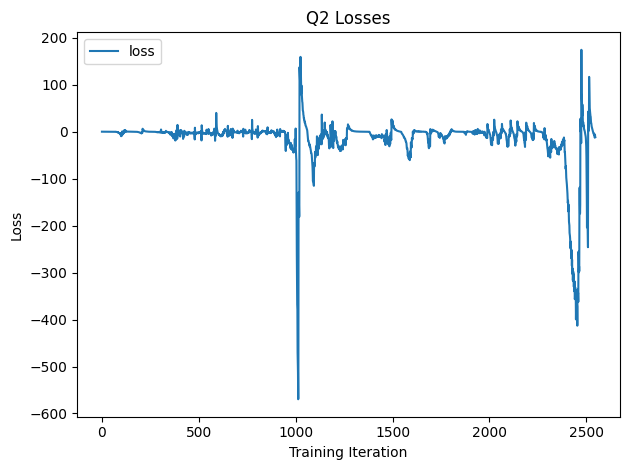

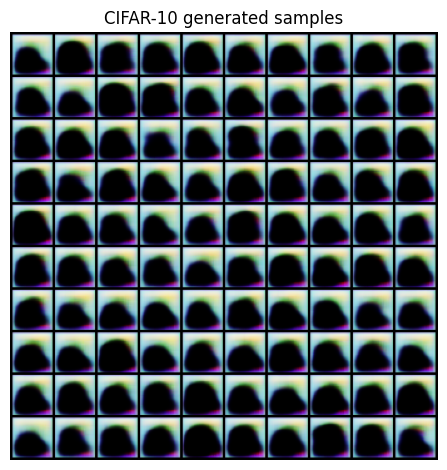

In [60]:
q2_save_results(q2)

# Question 3 : Quantization with GANS [40pt]
In this question, you'll train a variants of the VQGAN model to learn a mapping between image and a discrete codebook. We will do this on the CIFAR10 dataset.

## Part a: Vanilla VQGAN [25]
[VQGAN](https://github.com/CompVis/taming-transformers) extends the ideas from VQVAE by adding an additional GAN loss. Review HW 2 for more details on VQVAE, and may use your code from HW 2 (or HW2 solutions) to help with this question. Conceptually, the training procedure is the same as VQVAE, but with the addition of a discriminator network and its training.

Following the original VQGAN paper, we will use a patch-based discriminator. Split the image into 8x8 patches, which will be then fed into the discriminator. For the discrimiator you can use an architecture similar to the one used in the previous questions.
```
def Discriminator(*, n_filters=128):
    split to 8x8 patches
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.ReLU()
    global sum pooling
    nn.Linear(128, 1)
```

**Loss function**
We will use the loss function of

$L = L_{VQ} + 0.1 L_{GAN} + 0.5 L_{perceptual} + L_2$

Where $L_{VQ}$ is the VQ objective, $L_{GAN}$ is the GAN loss, $L_{perceptual}$ is the perceptual loss. 

For pytorch users, we provide the LPIPS loss from the original taming transformers paper ([found here](https://github.com/CompVis/taming-transformers/blob/master/taming/modules/losses/lpips.py)). An example of using the LPIPS loss is found below. If you are using a different framework, feel free to use any off the shelf code, just make sure to cite where you take it from.

Instead of using the adaptive weight on the GAN loss, we will use a fixed weight of 0.1.
* train for at least 15 epochs
* use a codebook size of 1024
* use Adam with betas=(0.5, 0.9) and 0 weight decay for both optimizers
* use the non-saturating formulation of the GAN objective.

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.

In [ ]:
# example usage of the LPIPS loss
from deepul.hw3_utils.lpips import LPIPS
loss = LPIPS()
x = torch.zeros(4, 3, 32, 32)
print(loss(x, x).mean())

In [ ]:
def q3a(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.  
    """

    """ YOUR CODE HERE """

    return discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test, reconstructions

In [ ]:
q3_save_results(q3a, "a") # with pips

## Part b: VIT-VQGAN [15]
In this part, you will replace the encoder and decoder in the VQGAN with a Vision Transformer (ViT) following the [Improved VQGAN paper](https://arxiv.org/abs/2110.04627). You may use pre-built ViT modules and/or transformers libraries for the purposes of this exercise. Split images into 4x4 patches which should give you 8x8 patches for each image.

**Discriminator**
In ViT-VQGAN, the patch-based discriminator is replaced with a full StyleGAN discriminator. For the purposes of this exercise, you should use the same discrimiator as described in part a but without splitting into patches. In addition add [spectral normalization](https://pytorch.org/docs/stable/generated/torch.nn.utils.spectral_norm.html#torch-nn-utils-spectral-norm) to all the conv and linear layers and use LeakyReLU instead of ReLU, following [SN-GANs](https://arxiv.org/abs/1802.05957). This is to help with training stability.
```
def Discriminator(*, n_filters=128):
    # all conv layers in the ResBlocks should have spectral normalization
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.LeakyReLU()
    global sum pooling
    nn.Linear(128, 1)
```
* in addition add 

**Loss function**
$L = L_{VQ} + 0.1 L_{GAN} + \alpha L_{perceptual} + L_2 + 0.1 L_1$

The ViT-VQGAN paper introduces a new loss term $L_{Logit\_laplace}$ which is a logit laplace loss. For simplicity, we will use an L1 loss instead.

If you implemented the perceptual loss in the previous part, you can use the same perceptual loss here, otherwise you may keep $\alpha = 0$.


You should be able to largely be able to reuse your implementations in the previous part for this problem
The only 3 updates you need are:
* use ViT for encoder and decoder of VQVAE, use 4 layers, 8 heads, and 256 for the embedding size 
* add L1 loss
* change the discrimiator to look at the full image

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.


In [ ]:
def q3b(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.  
    """

    """ YOUR CODE HERE """

    return discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test, reconstructions

In [ ]:
q3_save_results(q3b, "b")

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

In [ ]:
q4_save_results(q4)